# PheWAS

==============================================================================
<br>
Author: Pierre-Raphael Schiratti <br>
This code is adapted from Wenjia Bai's script on <br>
Bai, W., Suzuki, H., Huang, J. et al. A population-based phenome-wide <br>
association study of cardiac and aortic structure and function. Nat Med 26, <br>
1654–1662 (2020). https://doi.org/10.1038/s41591-020-1009-y <br>
==============================================================================

<b> Perform a phenome-wide association study (PheWAS) on polygenic risk score (PRS) with non-imaging phenotypes selected from the UK Biobank dataset. 

In [21]:
# Install dependencies
import numpy as np
import pandas as pd
import datetime
import scipy.stats
import math
import re
import rdata 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
from my_fdr import fdr_threshold
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [22]:
def normalise(x):
    # Normalise variable
    return (x - np.mean(x)) / np.std(x)

In [23]:
def rank_normalise(x):
    # Rank-based inverse normal transform
    # Please refer to the function inormal() in the FSLNets package

    # Get the rank of the values in x
    ri = np.argsort(np.argsort(x))

    # Correct for the ranks of repeated values
    # argsort assign different ranks for these values
    # We fill them with the same value
    u, inv_idx = np.unique(x, return_inverse=True)
    sii = np.sort(inv_idx)
    repeated_idx = np.unique(sii[np.diff(np.append(sii, 1)) == 0])
    for i in repeated_idx:
        ri[inv_idx == i] = np.mean(ri[inv_idx == i])

    # Perform inverse normal transform
    # ri + 1 so that the rank starts from 1, to be consistent with Karla's Matlab code
    # p squashes the rank into the range of [0, 1]
    # erfinv can generate a distribution from 2 * p - 1 with 0 mean and 1 standard deviation
    N = len(x)
    ri = ri + 1
    c = 3.0 / 8
    p = (ri - c) / (N - 2 * c + 1)
    y = math.sqrt(2) * scipy.special.erfinv(2 * p - 1)
    return y

In [24]:
def sizes_legend(desired_sizes, ax=None):
    # Adjust size of plot legend
    ax = ax or plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labels = np.array([float(l) for l in labels])
    desired_handles = [handles[np.argmin(np.abs(labels - d))] for d in desired_sizes]
    ax.legend(handles=desired_handles, labels=desired_sizes, title=ax.legend_.get_title().get_text(),
              loc='upper right')

In [25]:
def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

### Parameters for script execution

In [26]:
write_csv = True # flag to save intermediary files
plot = True # flag to plot data

result_path = r"./results"
data_path = r"./data"
non_idp_path = r"./data/my_ukbb_data_all_500.rda"

### Read polygenic risk score

In [27]:
df_prs = pd.read_csv(f'{data_path}/prs_pred.csv', index_col=0)

In [28]:
# filter with criteria: Europeans without MRI
# eur = pd.read_csv(f'{data_path}/European_samples_filtered_by_HapMapIII_CGRCh37_non_redacted.txt')
# mri = pd.read_csv(f'{data_path}/mri_39k.csv')
# mri.patient_id = mri.patient_id.str.split('/')[-1]
# mri.patient_id = mri.patient_id.astype(int)
# df_prs = df_prs[df_prs.eid_40616.isin(eur) & ~df_prs.eid_40616.isin(mri.patient_id)]

### Read non-imaging phenotypes

In [29]:
# Read ukbb non-imaging phenotypes data file
parsed = rdata.parser.parse_file(non_idp_path)
converted = rdata.conversion.convert(parsed)
df = converted['a'].copy(deep=True)

# Replace -2147483648 by None (importation error from RData)
df = df.replace(-2147483648,np.nan)

### Re-adapt ukbb data ###
# A dataframe with fields and IDs from non-imaging phenotypes
var = pd.DataFrame(data = df.columns, columns = ['name'])
var['ukbb_id'] = var.name.str.extract('_f(\d+)_\d+')
var = var.dropna(subset=['ukbb_id'])
var.ukbb_id = var.ukbb_id.astype(int)
var['rec'] = var.name.str.extract('_(\d+_\d+)$')

# Catalogue of category + field from UKBB
path_ukbb_field = rf"{data_path}/ukbb_reco_cat_field.csv"
ukbb_field = pd.read_csv(path_ukbb_field, encoding='utf-8')
ukbb_field.columns = ['cat_id', 'field_id', 'cat', 'field', 'cat_sup']
ukbb_field = ukbb_field.drop_duplicates(subset='field_id',keep='first')

# Match check between dataframe of variables and dataframe of definitions
df_match = pd.merge(var, ukbb_field, how='inner', left_on='ukbb_id', right_on='field_id') 
# Create new column name having field, and UID (field_id + rec_id)
df_match['new_id'] = df_match.ukbb_id.astype(str) + '-' + df_match.rec.str.replace('_','.')
df_match['new_name'] = df_match.field + '_' + df_match.new_id
# Order df_match by category name in ascending order, order of the plot
df_match = df_match.sort_values(by=['cat','field_id'])
if write_csv:
    df_match.to_csv(f'{result_path}/ukbb_fields_description.csv')

# Rename initial dataframe with new column names
df = df[['eid'] + df_match.name.tolist()]
df.columns = ['eid'] + df_match.new_name.values.tolist()
# Redefine and rename index
df.index = df.eid
df = df.drop(columns='eid')
df.index.names = ['eid_40616']
# Only keep rows present in prs dataframe and remove rows where sex is na
df = df.loc[df.index.isin(df_prs.index)]
df = df[df['Sex_31-0.0'].notna()]

### Confounding factors

In [30]:
df['Sex_31-0.0'] = df['Sex_31-0.0'].cat.codes.astype(int)
sex = df['Sex_31-0.0']
# Age provided by UK Biobank (21003-2.0) seems to be floored, i.e. with half a year error.
# To get more accurate age values, we calculate age by date.
month_dict = {"January": 1, 
              "February": 2, 
              "March": 3, 
              "April": 4, 
              "May": 5, 
              "June": 6, 
              "July": 7, 
              "August": 8, 
              "September": 9, 
              "October": 10, 
              "November": 11, 
              "December": 12}
df['Month of birth_52-0.0'] = df['Month of birth_52-0.0'].replace(month_dict)
df['Date of attending assessment centre_53-2.0'] = pd.to_datetime(df['Date of attending assessment centre_53-2.0'],unit='D', origin='1970-1-1').astype(str)
age = np.zeros(len(df))
for i in range(len(df)):
    # Calculate age
    try:
        d1 = datetime.date(df.iloc[i]['Year of birth_34-0.0'], df.iloc[i]['Month of birth_52-0.0'], 15)
        s = df.iloc[i]['Date of attending assessment centre_53-2.0']
        d2 = datetime.date(int(s[:4]), int(s[5:7]), int(s[8:]))
        age[i] = np.round((d2 - d1).days / 365.25, 1)
    except:
        age[i] = df.iloc[i]['Age when attended assessment centre_21003-2.0']

# Keep the rows with age, sex information
valid_idx = ~np.isnan(age) & ~np.isnan(sex)
df = df[valid_idx]
df_prs = df_prs[df_prs.index.isin(valid_idx[valid_idx].index)]
df_prs = df_prs[~df_prs.index.duplicated()]
sex = sex[valid_idx]
age = age[valid_idx]
age_age = age * age  # Age squared interaction

# Confounding factors: sex, age, age_age
conf = np.stack((sex, age, age_age), axis=1)
df_conf = pd.DataFrame(conf, index=df.index, columns=['Sex', 'Age', 'Age * Age'])
if write_csv:
    df_conf.to_csv(f'{result_path}/confounders_26k.csv')

# Remove confounding factors from df
df = df.drop(columns=[('Sex_31-0.0'),
                      ('Year of birth_34-0.0'),
                      ('Month of birth_52-0.0'),
                      ('Date of attending assessment centre_53-0.0'),
                      ('Date of attending assessment centre_53-1.0'),
                      ('Date of attending assessment centre_53-2.0'),
                      ('Age when attended assessment centre_21003-0.0'),
                      ('Age when attended assessment centre_21003-1.0'),
                      ('Age when attended assessment centre_21003-2.0'),
                      ])


### Clean, de-confound and normalise data

In [31]:
# This part of the code was adapted from Karla Miller's Matlab code at
# https://www.fmrib.ox.ac.uk/ukbiobank/gwaspaper/index.html
# Step 4.1: cleaning
n_subj, n_col = df.shape
bad_vars = []
for i in range(n_col):
    val = df.iloc[:, i]

    # Discard columns which are not numbers
    if df.iloc[:, i]._get_numeric_data().empty:
        bad_vars += [i]
        continue

    # Assume negative values are invalid, set them to NaN
    # There are also a lot of empty values, which are already NaN
    val[val < 0] = np.nan
    df.iloc[:, i] = val

    # Valid indices
    valid_idx = ~np.isnan(val)

    # Discard columns with more than 90% missing data
    if np.sum(valid_idx) < (0.1 * n_subj):
        bad_vars += [i]
        continue

    # Discard columns with over 95% elements with the exactly same value
    val_unique, counts = np.unique(val[valid_idx], return_counts=True)
    if np.max(counts) >= (0.95 * np.sum(valid_idx)):
        bad_vars += [i]
        continue

for i in range(n_col):
    for j in range(i + 1, n_col):
        if i in bad_vars or j in bad_vars:
            continue
        # Discard columns with very high correlation
        val_i = df.iloc[:, i]
        val_j = df.iloc[:, j]
        valid_idx = ~np.isnan(val_i) & ~np.isnan(val_j)
        if np.sum(valid_idx) < 2: # was ==0 before
            continue
        cc, _ = scipy.stats.pearsonr(val_i[valid_idx], val_j[valid_idx])
        if cc > 0.9999:
            # Keep the column with more valid elements
            if np.sum(~np.isnan(val_i)) > np.sum(~np.isnan(val_j)):
                bad_vars += [j]
            else:
                bad_vars += [i]

# The cleaned data
bad_vars = np.unique(bad_vars)
keep_vars = sorted(list(set(np.arange(n_col)) - set(bad_vars)))
df = df.iloc[:, keep_vars]
print('{0} columns kept after data cleaning.'.format(df.shape[1]))

# Step 4.2: normalise confounding factors
conf = (conf - np.mean(conf, axis=0)) / np.std(conf, axis=0)

# Step 4.3: normalise non imaging phenotypes
df_cont = pd.read_csv(f"{data_path}/continuous.csv", index_col=0)

n_col = df.shape[1]
not_in = []
for i in range(n_col):
    val = df.iloc[:, i]
    valid_idx = ~np.isnan(val)
    x = val[valid_idx]

    # Field ID
    field_id = int(re.search(r'_([0-9]*)-',df.columns[i]).group(1))

    # some are not in the continuous file?
    if field_id not in df_cont.index:
        is_continuous=False
        not_in.append(field_id)
        continue
    is_continuous = df_cont.loc[field_id]['continuous']

    if is_continuous:
        # If it is a continuous variable, perform standard normalisation.
        x = normalise(x)
    else:
        # If we are not sure whether it is a continuous or categorical variable, convert it
        # into a continuous variable using rank-based inverse normal transform.
        x = rank_normalise(x)
    df.iloc[:, i][valid_idx] = x
print(f'Were not in continuous file: {not_in}')
if write_csv:
    df.to_csv(f'{result_path}/normalised_non_IDPs_26k.csv')

# Step 4.4: de-confound and normalise IDPs+
n_row = conf.shape[1]
n_col = df_prs.shape[1]
beta = np.zeros((n_row, n_col))
for i in range(n_col):
    val = df_prs.iloc[:, i]
    valid_idx = ~np.isnan(val)
    x = val[valid_idx]
    beta[:, i] = np.dot(np.linalg.pinv(conf[valid_idx]), x)
    x = x - np.dot(conf[valid_idx], beta[:, i])
    x = normalise(x)
    df_prs.iloc[:, i][valid_idx] = x
df_beta = pd.DataFrame(beta,
                        index=['sex', 'age', 'sex * age'],
                        columns=df_prs.columns)
if write_csv:
    df_prs.to_csv(f'{result_path}/normalised_delta_26k.csv')
    df_beta.to_csv(f'{result_path}/beta_delta_26k.csv')

380 columns kept after data cleaning.
Were not in continuous file: []


### Uni-variate correlation studies

In [32]:
M = df_prs.shape[1]
N = df.shape[1]
corr = np.zeros((M, N))
corr_p = np.zeros((M, N))
for i in range(M):
    for j in range(N):
        # Remove NaNs
        x = df_prs.iloc[:, i]
        y = df.iloc[:, j]
        valid_idx = ~np.isnan(x) & ~np.isnan(y)
        x = x[valid_idx]
        y = y[valid_idx]

        # Pearson correlation
        cc, p_val = scipy.stats.pearsonr(x, y)
        corr[i, j] = cc
        corr_p[i, j] = p_val

# For p-value of 0, assign it with the mininal positive floating value
# so that we can calculate the logarithm for the Manhattan plot
corr_p[corr_p == 0] = np.finfo(np.float64).tiny

# Logarithm
log_corr_p = - np.log10(corr_p)

# Save the table
df_corr = pd.DataFrame(np.transpose(np.concatenate([corr, corr_p, log_corr_p])), index=df.columns, columns=['corr','corr_p','log_corr_p'])
if write_csv:
    df_corr.to_csv(f'{result_path}/table_corr_26k.csv')

# Bonferroni correction
M, N = corr.shape
p_bonf = 0.05 / (M * N)

# FDR correction
p_fdr, _ = fdr_threshold(corr_p.flatten(), 0.05)

# Number of phenotypes that is significantly associated with at least one of the IDPs
print('p_bonf = {0}'.format(p_bonf))
print('p_fdr = {0}'.format(p_fdr))
print('Number of correlations reaching Bonferroni threshold = {0}'.format(np.sum(corr_p < p_bonf)))
print('Number of correlations reaching FDR threshold = {0}'.format(np.sum(corr_p < p_fdr)))
print('Number of phenotypes reaching Bonferroni threshold = {0}'.format(np.sum(np.sum(corr_p < p_bonf, axis=0) > 0)))
print('Number of phenotypes reaching FDR threshold = {0}'.format(np.sum(np.sum(corr_p < p_fdr, axis=0) > 0)))


p_bonf = 0.00013157894736842105
p_fdr = 0
Number of correlations reaching Bonferroni threshold = 0
Number of correlations reaching FDR threshold = 0
Number of phenotypes reaching Bonferroni threshold = 0
Number of phenotypes reaching FDR threshold = 0


### Manhattan plot

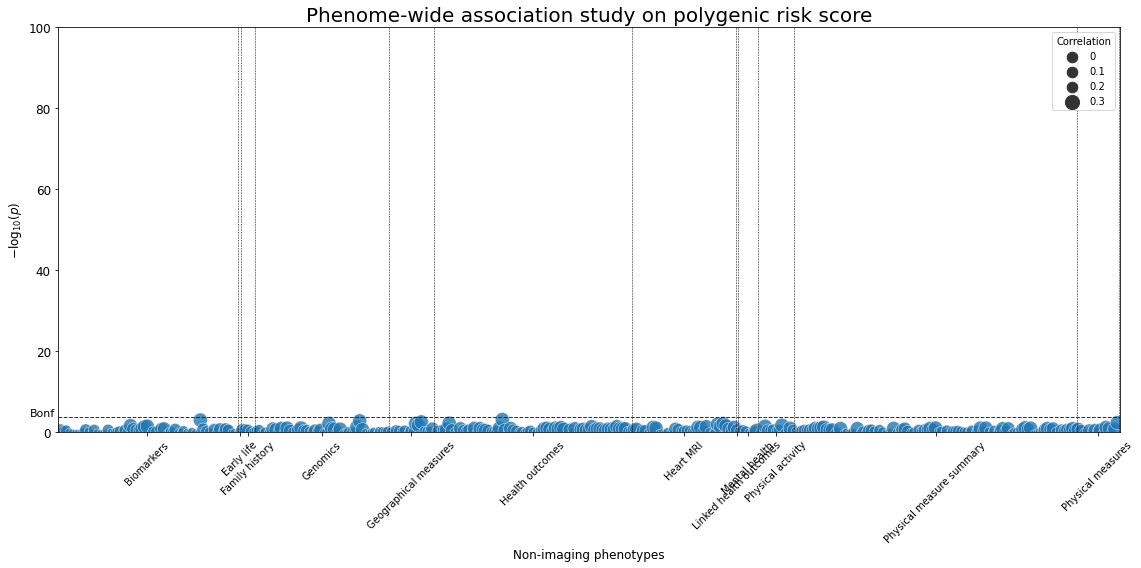

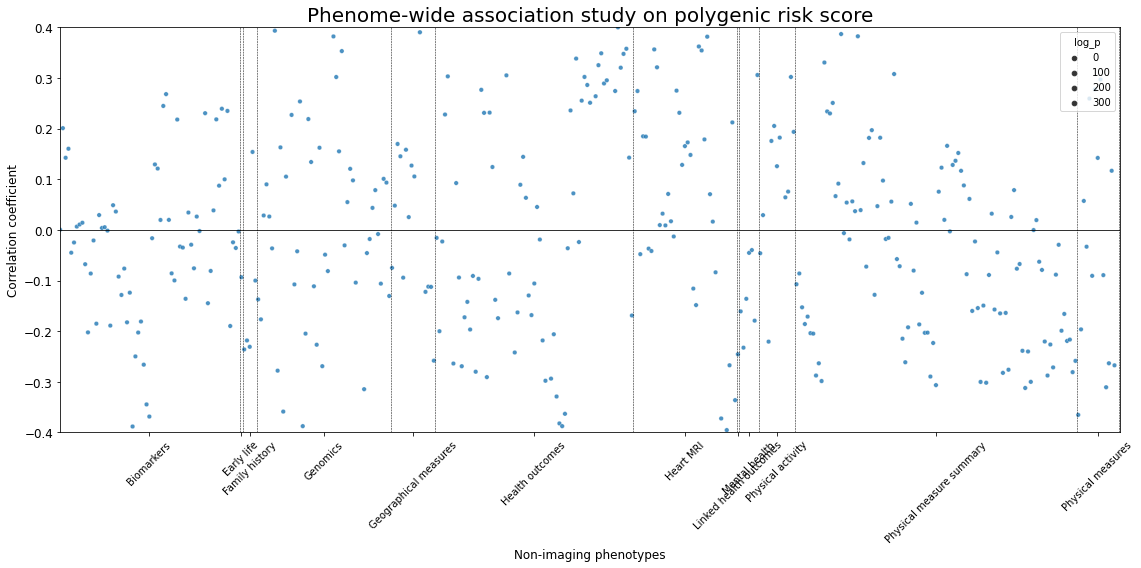

In [33]:
if plot:
    # Category for each field, ordered for the plot
    category = []
    for field_id in df.columns.str.extract(r'_([0-9]*)-').values:
        category += [ukbb_field.loc[ukbb_field.field_id==int(field_id),'cat']]
    category = np.array(category)

    # Dataframe with fields and associated correlations
    table = []
    s = 'Cardiac age delta'
    for j in range(N):
        line = [j, log_corr_p[0, j], corr[0, j], abs(corr[0, j]), s]
        table += [line]
    df_table = pd.DataFrame(table, columns=['x', 'log_p', 'corr', 'Correlation', 'Feature'])

    # Run for correlation plot and log plot
    var_d = {'log_p':{'y':'log_p',
                      'size':'Correlation',
                      'ylabel':r'$-\log_{10}(p)$',
                      'ylim_inf':0,
                      'ylim_sup':roundup(df_table.log_p.max()),
                      'size_min':-0.01,
                      'size_max':0.3,
                      'last_label':'0.3',
                      'desired_sizes':[0,0.1,0.2,0.3]
                      },
             'corr':{'y':'corr',
                     'size':'log_p',
                     'ylabel':r'Correlation coefficient',
                     'ylim_inf':-0.4,
                     'ylim_sup':0.4,
                     'size_min':0,
                     'size_max':300,
                     'last_label':'300',
                     'desired_sizes':[0,100,200,300]
                     }
             }

    for k,v in var_d.items():
        plt.figure()
        ax = sns.scatterplot(x='x', y=v['y'], size=v['size'],
                             sizes=(20,200), 
                             size_norm=mpl.colors.Normalize(vmin=v['size_min'], vmax=v['size_max']),
                             data=df_table, alpha=0.8)
        if k=='log_p':
            plt.plot([0, N], [-math.log10(p_bonf), -math.log10(p_bonf)], 'k--', linewidth=1, alpha=0.8)
            plt.text(-1, -math.log10(p_bonf), 'Bonf', horizontalalignment='right', fontsize=11)
        else:
            plt.plot([0, N], [0, 0], 'k-', linewidth=1, alpha=0.8)
        sizes_legend(v['desired_sizes'], ax)

        xticks = []
        xticklabels = []
        unique_category = ukbb_field.cat.unique()
        unique_category.sort()
        c_last = unique_category[-1]
        for c in unique_category:
            cid = np.nonzero(category == c)[0]
            if len(cid)==0:
                continue
            x = np.max(cid) + 0.5
            if c != c_last:
                plt.plot([x, x], [v['ylim_inf'], v['ylim_sup']], 'k--', linewidth=0.5)
            xticks += [np.mean(cid)]
            xticklabels += [c]

        plt.xlim(0, N)
        plt.ylim(v['ylim_inf'], v['ylim_sup'])
        plt.xticks(xticks, xticklabels, fontsize=10, rotation=45)
        plt.yticks(fontsize=12)
        plt.xlabel('Non-imaging phenotypes', fontsize=12)
        plt.ylabel(v['ylabel'], fontsize=12)
        plt.title('Phenome-wide association study on polygenic risk score',fontsize=20)
        fig = plt.gcf()
        fig.set_size_inches(16, 8)
        plt.tight_layout()
        plt.savefig(f'{result_path}/manhattan_plot_{k}.pdf', bbox_inches='tight')